# Задача

Необходимо классифицировать тестовые данные на два класса, используя временные ряды.

## Загрузка

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from statistics import mean
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from statsmodels.tsa.seasonal import seasonal_decompose

In [5]:
RANDOM_STATE=55
np.random.seed(55)

#### Train

In [7]:
train = pd.read_parquet("https://www.dropbox.com/scl/fi/smvtlcas8iel12d6l6lbt/train.parquet?rlkey=j3omi3zxfx4ki13s2r2auta67&st=dbqpihgg&dl=1")

In [8]:
train.head()

,id,dates,values,label
0,19114,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.86, 0.79, 1.4, 0.15, 0.0, -1.24, -1.46, 3....",0.0
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1.0
2,76935,"[2017-03-01, 2017-04-01, 2017-05-01, 2017-06-0...","[0.28, 0.63, 0.06, 0.96, -1.4, -0.3, 1.62, 1.1...",0.0
3,66297,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.33, 0.58, 1.1, -0.56, -0.95, -0.61, -0.7, ...",0.0
4,2191,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.31, 0.5, -0.54, 0.95, 0.65, 0.83, -1.55, -0...",0.0


In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80000 entries, 0 to 79999
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      80000 non-null  int64  
 1   dates   80000 non-null  object 
 2   values  80000 non-null  object 
 3   label   80000 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 2.4+ MB


В таблице присутствует 80000 строк с массивами дат, значений, так же присутствует ID - идентификатор объекта и целевая переменная - label.

In [11]:
train.shape

(80000, 4)

In [12]:
train['id'].duplicated().sum()

0

In [13]:
train['label'].unique()

array([0., 1.])

In [14]:
train['label'].value_counts()

label
0.0    57820
1.0    22180
Name: count, dtype: int64

Элементов с классом 0 в 2 раза больше, чем с классом 1

Из-за того, что имеются ограничения в ресурсах, возьмем подвыборку.

In [17]:
train['label'] = train['label'].astype('int')

Для того, чтобы "стратифицировать" класс 1, возьмем равное количество элементов 

In [19]:
ones = train[train['label']==1]
zeros = train[train['label']==0]

In [20]:
ones = ones[:5000]
zeros = zeros[:5000]

In [21]:
train = pd.concat([ones, zeros])

In [22]:
train.head()

,id,dates,values,label
1,22769,"[2016-05-01, 2016-06-01, 2016-07-01, 2016-08-0...","[-1.04, -3.48, 0.05, -0.13, -0.01, 0.03, 0.27,...",1
8,87449,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.92, 4.11, 3.39, -1.17, -0.79, 2.15, -0.22, ...",1
9,43415,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[-0.86, -0.05, -0.35, -0.67, -0.25, -0.8, -0.6...",1
18,94983,"[2019-11-01, 2019-12-01, 2020-01-01, 2020-02-0...","[0.92, 0.11, -0.16, 0.78, -0.49, 1.13, -0.55, ...",1
20,62582,"[2016-02-01, 2016-03-01, 2016-04-01, 2016-05-0...","[1.04, 0.44, 1.24, -1.1, 1.43, -0.53, -0.45, 0...",1


In [23]:
train.shape

(10000, 4)

Развернем данные из таблицы таким образом, чтобы каждому значению из dates соответствовала строка со значением из values

In [25]:
train['dates'] = train['dates'].apply(lambda x: [pd.to_datetime(d) for d in x])

In [26]:
new_train = pd.DataFrame({
  'id': train['id'].repeat(train['dates'].str.len()),
  'date': [date for dates in train['dates'] for date in dates],
  'value': [value for values in train['values'] for value in values],
  'label': train['label'].repeat(train['dates'].str.len())
})

In [27]:
new_train.head()

,id,date,value,label
1,22769,2016-05-01,-1.04,1
1,22769,2016-06-01,-3.48,1
1,22769,2016-07-01,0.05,1
1,22769,2016-08-01,-0.13,1
1,22769,2016-09-01,-0.01,1


In [28]:
new_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 643042 entries, 1 to 6913
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   id      643042 non-null  int64         
 1   date    643042 non-null  datetime64[ns]
 2   value   641939 non-null  float64       
 3   label   643042 non-null  int32         
dtypes: datetime64[ns](1), float64(1), int32(1), int64(1)
memory usage: 22.1 MB


В результате развертки подвыборки получаем 643042 строки

#### Test

Проделаем подобную развертку с тестовой выборкой

In [32]:
test = pd.read_parquet("https://www.dropbox.com/scl/fi/iy4il4b2248czc3bmd4kf/test.parquet?rlkey=d7z4q0wwelj0f7qpb1lj485pe&st=crox5j23&dl=1")

In [33]:
test.head()

,id,dates,values
0,6125,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[1.85, -0.04, 0.19, -0.45, -0.75, -0.95, -2.91..."
1,26781,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-0.41, 0.39, -0.47, -0.9, -1.46, -0.51, 0.51,..."
2,13333,"[2016-06-01, 2016-07-01, 2016-08-01, 2016-09-0...","[-0.29, -1.26, 0.17, -1.22, 0.45, -0.94, 0.16,..."
3,53218,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[-1.47, 1.55, -0.03, 0.57, -0.57, 0.6, 0.27, 1..."
4,84204,"[2016-01-01, 2016-02-01, 2016-03-01, 2016-04-0...","[2.33, 1.39, -1.03, -2.64, 1.89, 1.77, 1.43, 1..."


In [34]:
test.shape

(20000, 3)

In [35]:
test['dates'] = test['dates'].apply(lambda x: [pd.to_datetime(d) for d in x])

In [36]:
new_test = pd.DataFrame({
  'id': test['id'].repeat(test['dates'].str.len()),
  'date': [date for dates in test['dates'] for date in dates],
  'value': [value for values in test['values'] for value in values]
})

In [37]:
new_test.head()

,id,date,value
0,6125,2016-01-01,1.85
0,6125,2016-02-01,-0.04
0,6125,2016-03-01,0.19
0,6125,2016-04-01,-0.45
0,6125,2016-05-01,-0.75


In [38]:
len(new_test['id'].unique())

20000

In [39]:
new_test.shape

(1286952, 3)

В итоге, из 20000 строк получили 1286952 значения

## Анализ

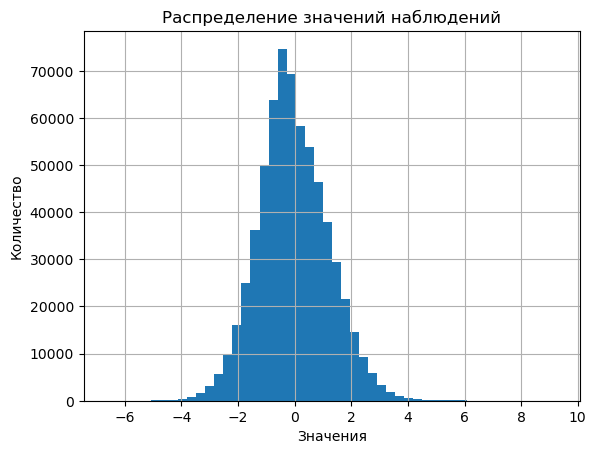

In [42]:
new_train['value'].hist(bins=50)
plt.title('Распределение значений наблюдений')
plt.xlabel('Значения')
plt.ylabel('Количество')
plt.show()

In [43]:
new_train['label'].value_counts()

label
0    324139
1    318903
Name: count, dtype: int64

Можно заметить, что распределение - нормальное и большее значение наблюдений находятся в пределах [-1, 0].

Из-за того, что временные ряды независимы друг от друга, возьмем один случайный элемент для анализа

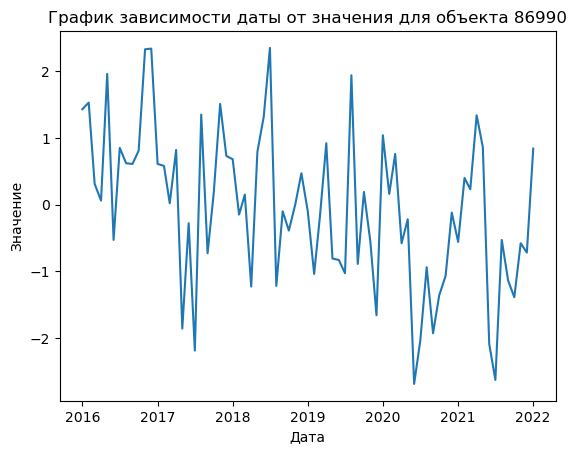

In [46]:
loced = new_train[new_train['id']==87499].loc[:, ['date', 'value']]
plt.plot(loced['date'], loced['value'])
plt.title('График зависимости даты от значения для объекта 86990')
plt.xlabel('Дата')
plt.ylabel('Значение')
plt.show()

В данном случае можем наблюдать тренд на уменьшение значения. Отчетливой сезонности не заметно

## Добавление признаков

Добавим признаки:
* скользящее среднее
* год
* месяц
* день недели
* смещение

#### Train

In [51]:
new_train = new_train.set_index(['id', 'date']).unstack(fill_value=0).stack().reset_index()
new_train['rolling_mean'] = new_train.groupby('id')['value'].transform(lambda x: x.rolling(window=3).mean())

C:\Users\Степан Сухарев\AppData\Local\Temp\ipykernel_14440\443918597.py:1: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  new_train = new_train.set_index(['id', 'date']).unstack(fill_value=0).stack().reset_index()


In [52]:
new_train['year'] = new_train['date'].dt.year 
new_train['month'] = new_train['date'].dt.month
#new_train['day'] = new_train['date'].dt.day 
new_train['day_of_week'] = new_train['date'].dt.dayofweek
new_train['lag_value_1'] = new_train['value'].shift(1)
new_train['lag_value_2'] = new_train['value'].shift(2)
new_train['lag_value_3'] = new_train['value'].shift(3)

In [53]:
new_train.head()

,id,date,value,label,rolling_mean,year,month,day_of_week,lag_value_1,lag_value_2,lag_value_3
0,15,2016-01-01,0.0,0,NaN,2016,1,4,NaN,NaN,NaN
1,15,2016-02-01,0.0,0,NaN,2016,2,0,0.0,NaN,NaN
2,15,2016-03-01,0.0,0,0.0,2016,3,1,0.0,0.0,NaN
3,15,2016-04-01,0.0,0,0.0,2016,4,4,0.0,0.0,0.0
4,15,2016-05-01,0.0,0,0.0,2016,5,6,0.0,0.0,0.0


In [54]:
new_train.dropna(inplace=True)

In [55]:
new_train.isna().sum()

id              0
date            0
value           0
label           0
rolling_mean    0
year            0
month           0
day_of_week     0
lag_value_1     0
lag_value_2     0
lag_value_3     0
dtype: int64

#### TEST

In [57]:
def additional_features(df):
    df = df.set_index(['id', 'date']).unstack(fill_value=0).stack().reset_index()
    df['rolling_mean'] = df.groupby('id')['value'].transform(lambda x: x.rolling(window=3).mean())
    df['year'] = df['date'].dt.year 
    df['month'] = df['date'].dt.month
    #new_train['day'] = new_train['date'].dt.day 
    df['day_of_week'] = df['date'].dt.dayofweek
    df['lag_value_1'] = df['value'].shift(1)
    df['lag_value_2'] = df['value'].shift(2)
    df['lag_value_3'] = df['value'].shift(3)
    df.dropna(inplace=True)
    return df

In [58]:
new_test = additional_features(new_test)

C:\Users\Степан Сухарев\AppData\Local\Temp\ipykernel_14440\998571782.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  df = df.set_index(['id', 'date']).unstack(fill_value=0).stack().reset_index()


In [59]:
new_test.head()

,id,date,value,rolling_mean,year,month,day_of_week,lag_value_1,lag_value_2,lag_value_3
3,2,2016-04-01,-1.00,0.190000,2016,4,4,0.08,1.49,0.78
4,2,2016-05-01,1.83,0.303333,2016,5,6,-1.00,0.08,1.49
5,2,2016-06-01,1.35,0.726667,2016,6,2,1.83,-1.00,0.08
6,2,2016-07-01,1.18,1.453333,2016,7,4,1.35,1.83,-1.00
7,2,2016-08-01,0.47,1.000000,2016,8,0,1.18,1.35,1.83


## Обучение модели

Удалим столбцы:
* id
* label
* date

### Подготовка модели

In [63]:
X = new_train.drop(columns=['id', 'label', 'date'])

In [64]:
X.head()

,value,rolling_mean,year,month,day_of_week,lag_value_1,lag_value_2,lag_value_3
3,0.0,0.0,2016,4,4,0.0,0.0,0.0
4,0.0,0.0,2016,5,6,0.0,0.0,0.0
5,0.0,0.0,2016,6,2,0.0,0.0,0.0
6,0.0,0.0,2016,7,4,0.0,0.0,0.0
7,0.0,0.0,2016,8,0,0.0,0.0,0.0


In [65]:
y = new_train['label']

In [66]:
y.head()

3    0
4    0
5    0
6    0
7    0
Name: label, dtype: int32

In [67]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False)

In [68]:
tscv = TimeSeriesSplit(n_splits=5)

### Baseline

In [70]:
dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train)
dummy_model_probas = dummy_clf.predict_proba(X_train)[:,1]
roc_auc_score(y_train, dummy_model_probas)

0.5

Модель сравнима с броском монеты

### Logistic Regression

In [73]:
lr = LogisticRegression()
parameters ={
    'C': range(1, 5)
}

RSCV = RandomizedSearchCV(lr, parameters, n_jobs=-1, cv=tscv, scoring='roc_auc')

RSCV.fit(X_train, y_train)
best_rfc = RSCV.best_estimator_
print('Best parameters:', RSCV.best_params_)
print('ROC-AUC of Logistic Regression:', abs(RSCV.best_score_))

C:\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'C': 3}
ROC-AUC of Logistic Regression: 0.5463024314365742


C:\anaconda\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Метрика модели не особо лучше, чем baseline модель

### Random Forest Classifier

In [76]:
rfc = RandomForestClassifier()

parameters = {
    'n_estimators': [100, 150, 200],
    'max_depth': range(3, 5)
}

RSCV = RandomizedSearchCV(rfc, parameters, n_jobs=-1, cv=tscv, scoring='roc_auc')

RSCV.fit(X_train, y_train)
best_rfc = RSCV.best_estimator_
print('Best parameters:', RSCV.best_params_)
print('ROC-AUC of Random Forest Classifier:', abs(RSCV.best_score_))

C:\anaconda\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 6 is smaller than n_iter=10. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters: {'n_estimators': 200, 'max_depth': 4}
ROC-AUC of Random Forest Classifier: 0.7815738440678359


Модель показывает хороший результат, но тратит много времени на работу

### CatBoostClassifier

In [79]:
cat = CatBoostClassifier()

parameters = {'learning_rate': [0.1, 0.2],
        'depth': [6, 10, 14],
        'l2_leaf_reg': [5, 7],
        'iterations': range(20, 60, 20)}

RSCV = RandomizedSearchCV(cat, parameters, n_jobs=-1, cv=tscv, scoring='roc_auc')

RSCV.fit(X_train, y_train)
best_rfc = RSCV.best_estimator_
print('Best parameters:', RSCV.best_params_)
print('ROC-AUC of Cat Boost Classifier:', abs(RSCV.best_score_))

0:	learn: 0.6604717	total: 517ms	remaining: 20.2s
1:	learn: 0.6333260	total: 862ms	remaining: 16.4s
2:	learn: 0.6109224	total: 1.25s	remaining: 15.5s
3:	learn: 0.5918419	total: 1.63s	remaining: 14.7s
4:	learn: 0.5754876	total: 1.97s	remaining: 13.8s
5:	learn: 0.5613636	total: 2.3s	remaining: 13.1s
6:	learn: 0.5490399	total: 2.65s	remaining: 12.5s
7:	learn: 0.5383557	total: 2.98s	remaining: 11.9s
8:	learn: 0.5289086	total: 3.34s	remaining: 11.5s
9:	learn: 0.5206135	total: 3.66s	remaining: 11s
10:	learn: 0.5132351	total: 4.02s	remaining: 10.6s
11:	learn: 0.5066637	total: 4.36s	remaining: 10.2s
12:	learn: 0.5009407	total: 4.73s	remaining: 9.82s
13:	learn: 0.4958360	total: 5.1s	remaining: 9.47s
14:	learn: 0.4912970	total: 5.42s	remaining: 9.03s
15:	learn: 0.4871880	total: 5.79s	remaining: 8.68s
16:	learn: 0.4835191	total: 6.11s	remaining: 8.26s
17:	learn: 0.4802240	total: 6.46s	remaining: 7.89s
18:	learn: 0.4772136	total: 6.83s	remaining: 7.54s
19:	learn: 0.4745173	total: 7.2s	remaining: 7

Модель показывает результат чуть лучше, чем случайный лес, имея при этом скорость работы выше

## Тестовая выборка

Для предсказания выберем модель CatBoostClassifier

In [83]:
new_test.head()

,id,date,value,rolling_mean,year,month,day_of_week,lag_value_1,lag_value_2,lag_value_3
3,2,2016-04-01,-1.00,0.190000,2016,4,4,0.08,1.49,0.78
4,2,2016-05-01,1.83,0.303333,2016,5,6,-1.00,0.08,1.49
5,2,2016-06-01,1.35,0.726667,2016,6,2,1.83,-1.00,0.08
6,2,2016-07-01,1.18,1.453333,2016,7,4,1.35,1.83,-1.00
7,2,2016-08-01,0.47,1.000000,2016,8,0,1.18,1.35,1.83


In [84]:
new_test.reset_index(drop=True, inplace=True)

In [85]:
test_predictions = RSCV.predict_proba(new_test)[:, 1]

In [86]:
predictions = pd.DataFrame(data=test_predictions, columns=['score'])

In [87]:
predictions['id'] = new_test['id']

In [88]:
predictions = predictions.reindex(columns=['id', 'score'])

In [89]:
submissions = predictions.groupby('id').mean().reset_index()

In [90]:
submissions.head()

,id,score
0,2,0.455705
1,6,0.285414
2,7,0.333734
3,13,0.407444
4,17,0.270572


In [91]:
submissions.shape

(20000, 2)

submissions.to_csv(r"D:\submissions\submissions.csv")